In [1]:
from keras.layers import InputLayer, Flatten, Dense, Reshape, Input, Dropout
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import Sequential
from keras.models import Model

Using TensorFlow backend.


In [2]:
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt

In [3]:
files = []
for r, d, f in os.walk('./emojies/'):
    for file in f:
            files.append(os.path.join(r, file))

dataset = np.zeros((len(files),72,72,4))
for i in range(0, len(files)):
    file = files[i]
    image = imageio.imread(file)
    if image.shape == (72,72,4):
        dataset[i] = image
print("Dataset shape is", dataset.shape)

Dataset shape is (2807, 72, 72, 4)


In [4]:
dataset = dataset.astype('float32') / 255

In [5]:
image_shape = (72,72,4)
encoding_dim = 3

In [6]:
def build_simple_autoencoder():
    encoder_input = Input(shape=image_shape)
    encoder_1 = Flatten()(encoder_input)
    encoder_2 = Dense(units=encoding_dim*3, activation="relu")(encoder_1)
    encoder_3 = Dense(units=encoding_dim*2, activation="relu")(encoder_2)
    encoder_4 = Dense(units=encoding_dim, activation="linear")(encoder_3)
    
    encoder = Model(encoder_input, encoder_4, name="encoder")

    decoder_input = Input(shape=(encoding_dim,))
    decoder_1 = Dense(units=encoding_dim*2, activation='relu')(decoder_input)
    decoder_2 = Dense(units=encoding_dim*3, activation='relu')(decoder_1)
    decoder_3 = Dense(units=72*72*4, activation='sigmoid')(decoder_2)
    decoder_4 = Reshape(target_shape=image_shape)(decoder_3)
    
    decoder = Model(decoder_input, decoder_4, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [11]:
def build_dens_autoencoder():
    
    encoder_input = Input(shape=image_shape, name='encoder_0')
    encoder_1 = Conv2D(128, (7, 7), activation='relu', padding='same', name='encoder_1')(encoder_input)
    encoder_2 = MaxPooling2D((2, 2), padding='same', name='encoder_2')(encoder_1)
    encoder_3 = Conv2D(32, (2, 2), activation='relu', padding='same', name='encoder_3')(encoder_2)
    encoder_4 = MaxPooling2D((2, 2), padding='same', name='encoder_4')(encoder_3)
    encoder_5 = Conv2D(1, (7, 7), activation='relu', padding='same', name='encoder_5')(encoder_4)
    
    encoder = Model(encoder_input, encoder_5, name="encoder")

    decoder_input = Input(shape=(18, 18, 1))
#     decoder_input = Input(shape=(7, 7, 1))
    decoder_1 = Conv2D(32, (7, 7), activation='relu', padding='same')(decoder_input)
    decoder_2 = UpSampling2D((2, 2))(decoder_1)
    decoder_3 = Conv2D(128, (2, 2), activation='relu', padding='same')(decoder_2)
    decoder_4 = UpSampling2D((2, 2))(decoder_3)
    decoder_5 = Conv2D(4, (7, 7), activation='sigmoid', padding='same')(decoder_4)
    
    decoder = Model(decoder_input, decoder_5, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [12]:
# encoder, decoder, autoencoder = build_simple_autoencoder()
encoder, decoder, autoencoder = build_dens_autoencoder()

In [13]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_0 (InputLayer)       (None, 72, 72, 4)         0         
_________________________________________________________________
encoder_1 (Conv2D)           (None, 72, 72, 128)       25216     
_________________________________________________________________
encoder_2 (MaxPooling2D)     (None, 36, 36, 128)       0         
_________________________________________________________________
encoder_3 (Conv2D)           (None, 36, 36, 32)        16416     
_________________________________________________________________
encoder_4 (MaxPooling2D)     (None, 18, 18, 32)        0         
_________________________________________________________________
encoder_5 (Conv2D)           (None, 18, 18, 1)         1569      
Total params: 43,201
Trainable params: 43,201
Non-trainable params: 0
_________________________________________________________________


In [14]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 18, 18, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 32)        1600      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 36, 128)       16512     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 72, 72, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 4)         25092     
Total params: 43,204
Trainable params: 43,204
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit(dataset, dataset,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(dataset, dataset))

Train on 2807 samples, validate on 2807 samples
Epoch 1/50
 256/2807 [=>............................] - ETA: 3:35 - loss: 0.6694

TypeError: Invalid dimensions for image data

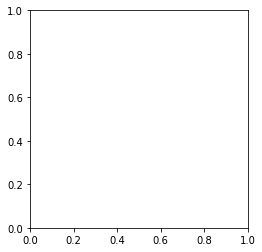

In [211]:
i = 40
imgs = dataset[i:i+1]
predicted_imgs = autoencoder.predict(imgs, batch_size=1)
for ind in range(0,len(imgs)):
    plt.imshow(predicted_imgs[ind])
    plt.show()
    plt.imshow(imgs[ind])
    plt.show()

In [230]:
imgs = dataset[0:10]
encoded_imgs = encoder.predict(imgs)
for encoded_img in encoded_imgs:
    print(encoded_img.shape)

(18, 18, 1)
(18, 18, 1)
(18, 18, 1)
(18, 18, 1)
(18, 18, 1)
(18, 18, 1)
(18, 18, 1)
(18, 18, 1)
(18, 18, 1)
(18, 18, 1)


In [231]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=1)
for decoded_img in decoded_imgs:
    print(decoded_img.shape)
#     plt.imshow(decoded_img)
#     plt.show()

(72, 72, 1)
(72, 72, 1)
(72, 72, 1)
(72, 72, 1)
(72, 72, 1)
(72, 72, 1)
(72, 72, 1)
(72, 72, 1)
(72, 72, 1)
(72, 72, 1)


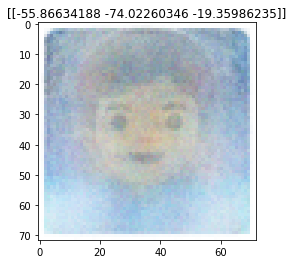

In [201]:
seeds = np.random.uniform(low=-100.0, high=100.0, size=(1,encoding_dim))
# seeds = np.random.normal(loc=0.0, scale=20.0, size=(1,encoding_dim))
# seeds = np.random.beta(a=0.6, b=1.2, size=(1,encoding_dim))
generated_imgs = decoder.predict(seeds, batch_size=1)
for generated_img in generated_imgs:
    plt.imshow(generated_img)
    plt.title(str(seeds))
    plt.show()

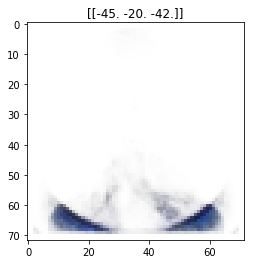

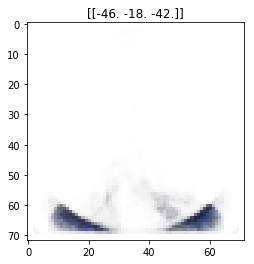

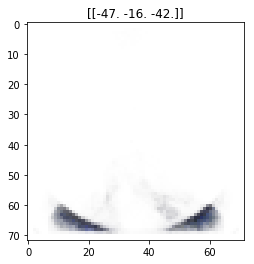

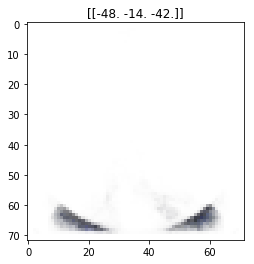

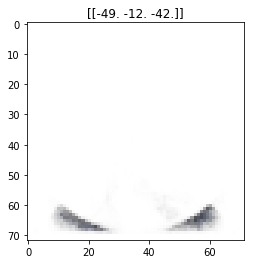

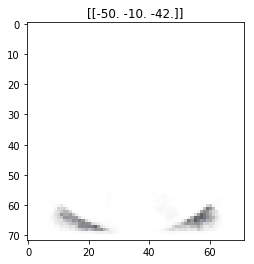

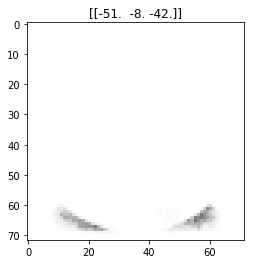

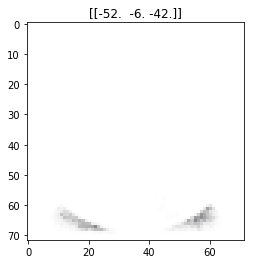

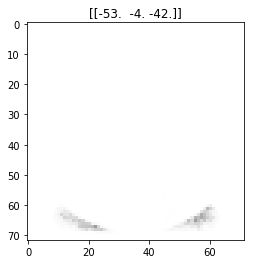

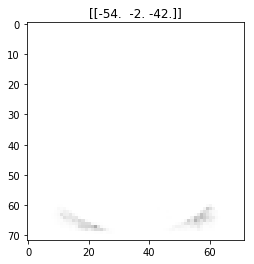

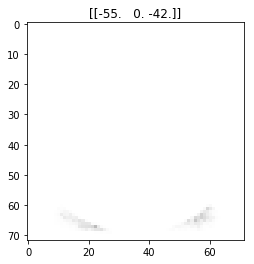

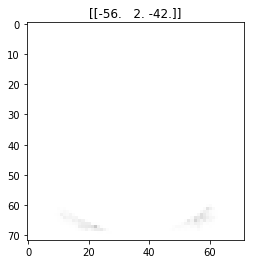

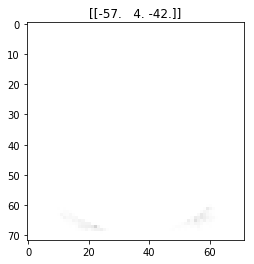

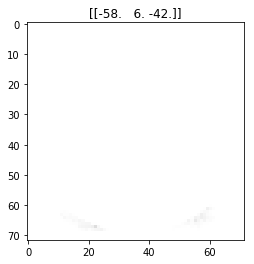

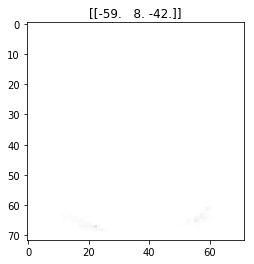

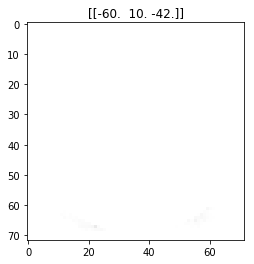

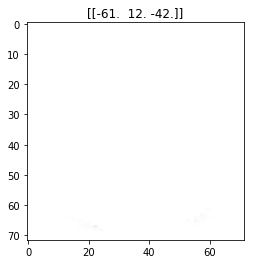

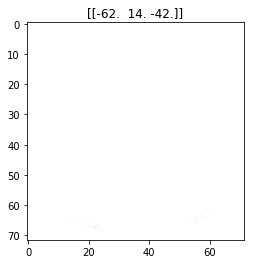

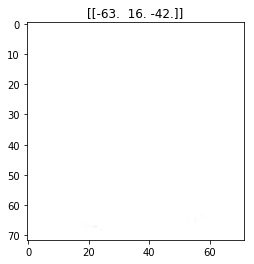

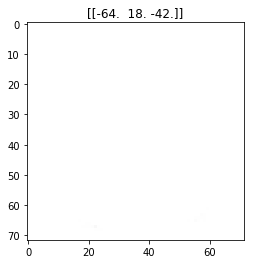

In [169]:
for i in range(-10, 10):
    seeds = np.array([[-73.0 - i, 0.0 + 2*i, -42.0]])
    generated_imgs = decoder.predict(seeds, batch_size=1)
    for generated_img in generated_imgs:
        plt.imshow(generated_img)
        plt.title(str(seeds))
        plt.show()